In [28]:
import numpy
from matplotlib import pyplot as plt
import h5py
import glob
from scipy import signal
import matplotlib.mlab as mlab
plt.ion()

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'].value
    #print meta.keys()
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc



#fnames=glob.glob("[HL]-*.hdf5")
#fname=fnames[0]


fname = 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
print('Reading file', fname)
strain_H, dt_H, utc_H = read_file(fname)

fname = 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
print('Reading file', fname)
strain_L, dt_L, utc_L = read_file(fname)

template_name = 'GW150914_4_template.hdf5'
print('Reading template', template_name)
th, tl = read_template(template_name)


#spec,nu=measure_ps(strain,do_win=True,dt=dt,osamp=16)
#strain_white=noise_filter(strain,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)

#th_white=noise_filter(th,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)
#tl_white=noise_filter(tl,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)


#matched_filt_h=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(th_white)))
#matched_filt_l=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(tl_white)))




#copied from bash from class
# strain2=np.append(strain,np.flipud(strain[1:-1]))
# tobs=len(strain)*dt
# k_true=np.arange(len(myft))*dnu

Reading file H-H1_LOSC_4_V2-1126259446-32.hdf5
Reading file L-L1_LOSC_4_V2-1126259446-32.hdf5
Reading template GW150914_4_template.hdf5


Use 4096 Hz sampling rate from file L-L1_LOSC_4_V2-1126259446-32.hdf5


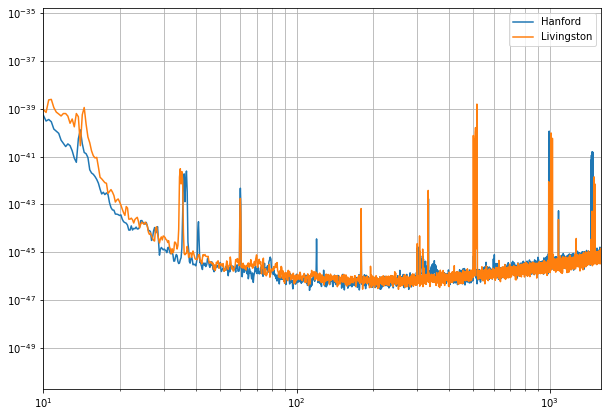

In [23]:
# Both Hanford and Livingston have the same sampling rate
dt = dt_L
samp = int(1/dt)
print('Use', samp, 'Hz sampling rate from file', fname)

NFFT = 4*samp # use 4 seconds of data for each fourier transform
n_overlap = NFFT/2 # overlap half the points
# Use a Hanning window along with Welch's method:

# psd_window = signal.turkey(NFFT, alpha=1/4)
psd_window = signal.hann(NFFT)

PSD_H, freq = mlab.psd(strain_H, Fs=samp, NFFT=NFFT, window=psd_window, noverlap=n_overlap)
PSD_L, freq = mlab.psd(strain_L, Fs=samp, NFFT=NFFT, window=psd_window, noverlap=n_overlap)

# Plot the Welch-averaged PSDs
plt.figure(figsize=(10,7))
plt.loglog(freq, PSD_H, label='Hanford')
plt.loglog(freq, PSD_L, label='Livingston')
plt.xlim(10,1600)
plt.legend()
plt.grid(which='both')





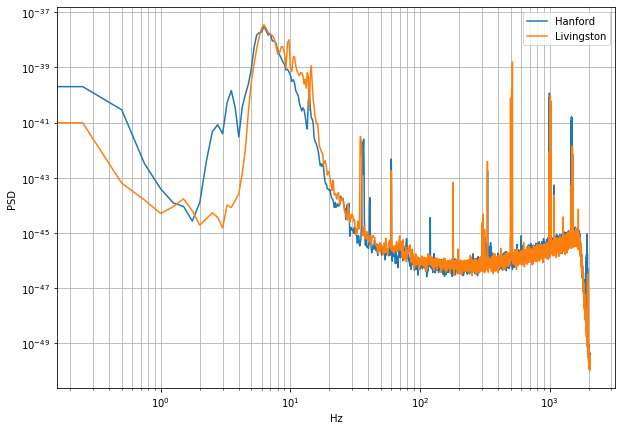

In [24]:
# Use the power spectral density of each instrument as the respective noise model
# noise_H = np.abs(np.fft.rfft(strain_H*np.hanning(len(strain_H))))**2
# noise_L = np.abs(np.fft.rfft(strain_L*np.hanning(len(strain_L))))**2

# Convert the time axis to Fourier space using np.fft.rfftfreq()
# freq = np.fft.rfftfreq(len(strain_H), dt)

# Use Welch's method to get the power spectral density (PSD) of the Hanford and Livingston data.
# Consider the PSD to be the noise model for its respective instrument.
# Welch's method smooths the noise model by averaging overlapping segments of the data.
NFFT = 4*samp # use 4 seconds of data for each fourier transform
n_overlap = NFFT/2 # overlap half the points
# Use a Hanning window along with Welch's method:
freq, noise_avg_H = signal.welch(strain_H, fs=samp, nfft=NFFT, window='hanning', noverlap=n_overlap, nperseg=NFFT) 
freq, noise_avg_L = signal.welch(strain_L, fs=samp, nfft=NFFT, window='hanning', noverlap=n_overlap, nperseg=NFFT)

plt.figure(figsize=(10,7))

# plt.loglog(freq, noise_H, alpha=0.85, label='Hanford')
# plt.loglog(freq, noise_L, alpha=0.85, label='Livingston')

plt.loglog(freq, noise_avg_H, label='Hanford')
plt.loglog(freq, noise_avg_L, label='Livingston')

plt.grid(which='both')
plt.xlabel('Hz')
plt.ylabel('PSD')
# plt.xlim(10,1600)
plt.legend()

In [25]:
import json
fnjson = "LOSC_Event_tutorial/BBH_events_v3.json"

events = json.load(open(fnjson,"r"))
eventname = 'GW150914' 

event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{'name': 'GW150914', 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'fn_template': 'GW150914_4_template.hdf5', 'fs': 4096, 'tevent': 1126259462.44, 'utcevent': '2015-09-14T09:50:45.44', 'm1': 41.743, 'm2': 29.237, 'a1': 0.355, 'a2': -0.769, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 300.0], 'f_min': 10.0}


In [29]:
import numpy as np
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*samp
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# define the complex template, common to both detectors:
template = (th + t1*1.j) 
# We will record the time where the data match the END of the template.
#etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*samp
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
#try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
dwindow = signal.blackman(template.size)   

template_fft = np.fft.fft(template*dwindow) / samp

PSD_H, freq = mlab.psd(strain_H, Fs=samp, NFFT=NFFT, window=psd_window, noverlap=n_overlap)
PSD_L, freq = mlab.psd(strain_L, Fs=samp, NFFT=NFFT, window=psd_window, noverlap=n_overlap)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
PSD_H_fft = np.fft.fft(PSD_H*dwindow) / samp
PSD_L_fft = np.fft.fft(PSD_L*dwindow) / samp

plt.figure(figsize=(10,7))

# plt.loglog(freq, noise_H, alpha=0.85, label='Hanford')
# plt.loglog(freq, noise_L, alpha=0.85, label='Livingston')

plt.loglog(datafreq, PSD_H_fft, label='Hanford')
plt.loglog(freq, PSD_L_fft, label='Livingston')

plt.grid(which='both')
plt.xlabel('Hz')
plt.ylabel('PSD')
# plt.xlim(10,1600)
plt.legend()

    # -- Interpolate to get the PSD values at the needed frequencies
power_vec = np.interp(np.abs(datafreq), freqs, data_psd)




NameError: name 't1' is not defined

In [20]:
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# define the complex template, common to both detectors:
template = (th + t1*1.j) 
# We will record the time where the data match the END of the template.
#etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*samp
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
#try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / samp

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
          .format(det,timemax,SNRmax,d_eff,horizon))

    if make_plots:

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        # -- Plot the result
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.title(det+' matched filter SNR around event')

        # zoom in
        plt.subplot(2,1,2)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlim([-0.15,0.05])
        #plt.xlim([-0.3,+0.3])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.savefig(eventname+"_"+det+"_SNR."+plottype)

        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(time-tevent,template_match,'k',label='Template(t)')
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' whitened data around event')

        plt.subplot(2,1,2)
        plt.plot(time-tevent,strain_whitenbp-template_match,pcolor,label=det+' resid')
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' Residual whitened data after subtracting template around event')
        plt.savefig(eventname+"_"+det+"_matchtime."+plottype)
                 
        # -- Display PSD and template
        # must multiply by sqrt(f) to plot template fft on top of ASD:
        plt.figure(figsize=(10,6))
        template_f = np.absolute(template_fft)*np.sqrt(np.abs(datafreq)) / d_eff
        plt.loglog(datafreq, template_f, 'k', label='template(f)*sqrt(f)')
        plt.loglog(freqs, np.sqrt(data_psd),pcolor, label=det+' ASD')
        plt.xlim(20, fs/2)
        plt.ylim(1e-24, 1e-20)
        plt.grid()
        plt.xlabel('frequency (Hz)')
        plt.ylabel('strain noise ASD (strain/rtHz), template h(f)*rt(f)')
        plt.legend(loc='upper left')
        plt.title(det+' ASD and template around event')
        plt.savefig(eventname+"_"+det+"_matchfreq."+plottype)

NameError: name 'fs' is not defined